Neste projeto, será realizada uma análise para a empresa Y.Afisha com o objetivo de otimizar os investimentos em marketing. A análise será baseada em três fontes principais de dados:

* Logs do servidor com dados sobre os acessos a Y.Afisha de janeiro de 2017 até dezembro de 2018
* Arquivo de despejo (ou dump file, em inglês) com todos os pedidos feitos durante o período
* Estatísticas de despesas com marketing

A partir desses dados, a análise buscará responder às seguintes questões:
* Como os usuários utilizam o produto?
* Quando eles começam a comprar após o primeiro acesso?
* Qual é o valor gerado por cliente ao longo do tempo?
* Em quanto tempo os investimentos em marketing são recuperados?

A abordagem será dividida em três partes principais:
* **Preparação dos dados:** importação, otimização e verificação dos tipos de dados.
* **Cálculo de métricas e elaboração de relatórios** para os seguintes blocos:
    * Produto: número de usuários por período, frequência de sessões, tempo médio de sessão, retorno de usuários.
    * Vendas: tempo até a primeira compra, frequência de pedidos, volume médio de compras e LTV.
    * Marketing: gastos totais e por origem, custo de aquisição por canal, análise de ROI.
* **Conclusão:** recomendações baseadas em desempenho por origem e dispositivo, com sugestões de otimização dos investimentos em marketing.

Gráficos serão usados ao longo da análise para visualizar variações entre dispositivos, canais de aquisição e períodos de tempo.

## Descrição dos dados
Tabela visits (os logs do servidor com dados sobre os acessos ao site):
* Uid — identificador unívoco do usuário
* Device — dispositivo do usuário
* Start Ts — data e hora do início da sessão
* End Ts — data e hora do final da sessão
* Source Id — identificador da origem do anúncio através do qual o usuário chegou
Todas as datas nesta tabela estão no formato YYYY-MM-DD.

Tabela orders (dados sobre os pedidos):
* Uid — identificador unívoco do usuário que faz um pedido
* Buy Ts — data e hora do pedido
* Revenue — a receita da Y.Afisha com o pedido

Tabela costs (dados sobre as despesas com marketing):
* source_id — identificador da origem de anúncio
* dt — data
* costs — despesas com esta origem de anúncio neste dia

## 1. Inicialização e preparação dos dados

In [1]:
# importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
# leitura dos df
visits = pd.read_csv('datasets/visits_log_us.csv')
orders = pd.read_csv('datasets/orders_log_us.csv')
costs = pd.read_csv('datasets/costs_us.csv')

### df `visits`
Apresenta os logs do servidor com dados sobre os acessos ao site:
* Uid — identificador unívoco do usuário
* Device — dispositivo do usuário
* Start Ts — data e hora do início da sessão
* End Ts — data e hora do final da sessão
* Source Id — identificador da origem do anúncio através do qual o usuário chegou

Todas as datas nesta tabela estão no formato YYYY-MM-DD.

In [3]:
# impressão das informações do df
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
# amostra de dados do df
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
# verifica se há linhas completamente duplicadas
visits.duplicated().sum()

np.int64(0)

* É necessário padronizar o título das colunas.
* É preciso transformar os dados das colunas `End Ts` e `Start Ts` para datetime. Verificar se o identificador do usuário precisa ser transformado também.
* Não há dados ausentes aparentes. 
* Não há linhas completamente duplicadas

In [6]:
# padroniza o título das colunas: remove espaços, deixa lowercase e snake_case
new_col_names_visits = [] # lista de novos nomes para as colunas

for old_name in visits.columns: 
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    new_col_names_visits.append(name_no_spaces)

# substitui os nomes antigos pelos novos
visits.columns = new_col_names_visits 

In [7]:
# converte os dados das colunas para datetime
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

É posssível que a coluna `devices` possua valores padronizados (categorias).

In [8]:
# conta os valores unívocos da coluna
visits['device'].value_counts()

device
desktop    262567
touch       96833
Name: count, dtype: int64

Há apenas 2 valores nesta coluna, presumivelmente categorias de dispositivos (computador e dispositivo touch), então os dados dessa coluna serão convertidos para o tipo category.

In [9]:
visits['device'] = visits['device'].astype('category')

In [10]:
# verifica os valores únicos da coluna
visits['uid'].nunique()

228169

Verifica-se que há mais entradas de logs do que identificadores únicos de usuários, o que sugere que alguns usuários acessaram o site mais de uma vez.

**Alterações no df para uma melhor interpretação**

Este DataFrame pode ser relacionado ao DataFrame `costs` pelas colunas `source_id` e pela data da visita e do anúncio, ou ao DataFrame `orders` pela data da compra. 

Para gerar as coortes por mês, será criada uma coluna que apresente o mês de cada visita.

Além disso, as colunas serão reordenadas para que os dados fiquem organizados de forma mais lógica.

In [11]:
# cria uma coluna com apenas o mês da visita
visits['visit_month'] = visits['start_ts'].dt.to_period('M')

In [12]:
# ordena as colunas do df
new_order_visits = ['uid', 'device', 'source_id', 'start_ts', 'end_ts', 'visit_month']
visits = visits[new_order_visits]

In [13]:
# impressão das informações do df para verificar as alterações
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uid          359400 non-null  uint64        
 1   device       359400 non-null  category      
 2   source_id    359400 non-null  int64         
 3   start_ts     359400 non-null  datetime64[ns]
 4   end_ts       359400 non-null  datetime64[ns]
 5   visit_month  359400 non-null  period[M]     
dtypes: category(1), datetime64[ns](2), int64(1), period[M](1), uint64(1)
memory usage: 14.1 MB


In [14]:
# amostra de dados do df para verificar os dados da nova coluna
visits.head()

,uid,device,source_id,start_ts,end_ts,visit_month
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12


### df `orders`
Apresenta dados sobre os pedidos:
* Uid — identificador unívoco do usuário que faz um pedido
* Buy Ts — data e hora do pedido
* Revenue — a receita da Y.Afisha com o pedido

In [15]:
# impressão das informações do df
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [16]:
# amostra de dados do df
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [17]:
# verifica se há linhas completamente duplicadas
orders.duplicated().sum()

np.int64(0)

* É necessário padronizar o título das colunas.
* É preciso transformar os dados da coluna `Buy Ts` para datetime. 
* Não há dados ausentes aparentes. 
* Não há linhas completamente duplicadas

In [18]:
# padroniza o título das colunas: remove espaços, deixa lowercase e snake_case
new_col_names_orders = [] # lista de novos nomes para as colunas

for old_name in orders.columns: 
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    new_col_names_orders.append(name_no_spaces)

# substitui os nomes antigos pelos novos
orders.columns = new_col_names_orders

In [19]:
# converte os dados da coluna para datetime
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [20]:
# impressão das informações do df para verificar as alterações
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [21]:
# verifica os valores únicos da coluna
orders['uid'].nunique()

36523

Verifica-se que há mais entradas de pedidos do que identificadores únicos de usuários, o que indica que alguns usuários realizaram mais de um pedido no site.

**Alterações no df para uma melhor interpretação**

Assim como no df `vistis`, será criada uma coluna neste df que apresente o mês de cada compra.

Além disso, as colunas serão reordenadas para que os dados fiquem organizados de forma mais lógica.

In [22]:
# cria uma coluna com apenas o mês da compra
orders['order_month'] = orders['buy_ts'].dt.to_period('M')

In [23]:
# ordena as colunas do df
new_order_orders = ['uid', 'buy_ts', 'order_month', 'revenue']
orders = orders[new_order_orders]

In [24]:
# impressão das informações do df para verificar as alterações
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uid          50415 non-null  uint64        
 1   buy_ts       50415 non-null  datetime64[ns]
 2   order_month  50415 non-null  period[M]     
 3   revenue      50415 non-null  float64       
dtypes: datetime64[ns](1), float64(1), period[M](1), uint64(1)
memory usage: 1.5 MB


### df `costs` 
Apresenta dados sobre as despesas com marketing:
* source_id — identificador da origem de anúncio
* dt — data
* costs — despesas com esta origem de anúncio neste dia

In [25]:
# impressão das informações do df
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [26]:
# amostra de dados do df
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [27]:
# verifica se há linhas completamente duplicadas
costs.duplicated().sum()

np.int64(0)

* É preciso transformar os dados da coluna `dt` para datetime. 
* Não há dados ausentes aparentes. 
* Não há linhas completamente duplicadas

In [28]:
# converte os dados da coluna para datetime
costs['dt'] = pd.to_datetime(costs['dt'])

In [29]:
# cria uma coluna com apenas o mês da despesa
costs['cost_month'] = costs['dt'].dt.to_period('M')

In [30]:
# impressão das informações do df para verificar as alterações
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   source_id   2542 non-null   int64         
 1   dt          2542 non-null   datetime64[ns]
 2   costs       2542 non-null   float64       
 3   cost_month  2542 non-null   period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), period[M](1)
memory usage: 79.6 KB


## 2. Cálculo de métricas e elaboração de relatórios

### df `visits`
Serão analisadas as questões:
* Quantas pessoas usam-no cada dia, semana e mês?
* Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).
* Que comprimento tem cada sessão?
* Com que frequência os usuários voltam?


####  Quantas pessoas usam-no cada dia, semana e mês?

In [31]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uid          359400 non-null  uint64        
 1   device       359400 non-null  category      
 2   source_id    359400 non-null  int64         
 3   start_ts     359400 non-null  datetime64[ns]
 4   end_ts       359400 non-null  datetime64[ns]
 5   visit_month  359400 non-null  period[M]     
dtypes: category(1), datetime64[ns](2), int64(1), period[M](1), uint64(1)
memory usage: 14.1 MB


In [32]:
# cria coluna com a semana da visita e coluna com o dia da visita (sem horário)
visits['visit_week'] = visits['start_ts'].dt.to_period('W')  
visits['visit_date'] = visits['start_ts'].dt.to_period('D')

In [33]:
# cálculo das médias das métricas (número de usuários por dia, semana e mês)
dau_visits = visits.groupby('visit_date').agg({'uid':'nunique'}).mean()
wau_visits = visits.groupby('visit_week').agg({'uid':'nunique'}).mean()
mau_visits = visits.groupby('visit_month').agg({'uid':'nunique'}).mean()

In [34]:
print('Número médio de usuários por dia:', int(dau_visits.iloc[0]))
print('Número médio de usuários por semana:', int(wau_visits.iloc[0]))
print('Número médio de usuários por mês:', int(mau_visits.iloc[0]))

Número médio de usuários por dia: 907
Número médio de usuários por semana: 5716
Número médio de usuários por mês: 23228


Para verificar o comportamento dos usuários, também será analisada a quantidade mensal de usuários que visitam o site a partir dos diferentes tipos de dispositivos: computadores (desktop) e aparelhos touch screen (touch).

In [35]:
# cálculo do número de usuários que visitaram o site a cada mês para cada tipo de dispositivo

monthly_users_by_device = visits.pivot_table(index='visit_month',
                                       columns='device',
                                       values='uid',
                                       aggfunc='nunique',
                                       observed=False)

monthly_users_by_device

device,desktop,touch
visit_month,,
2017-06,9761,3655
2017-07,10145,4223
2017-08,8611,3132
2017-09,13509,5679
2017-10,21286,8856
2017-11,24439,8913
2017-12,23294,8785
2018-01,20350,8741
2018-02,20574,8590


<Figure size 1300x900 with 0 Axes>

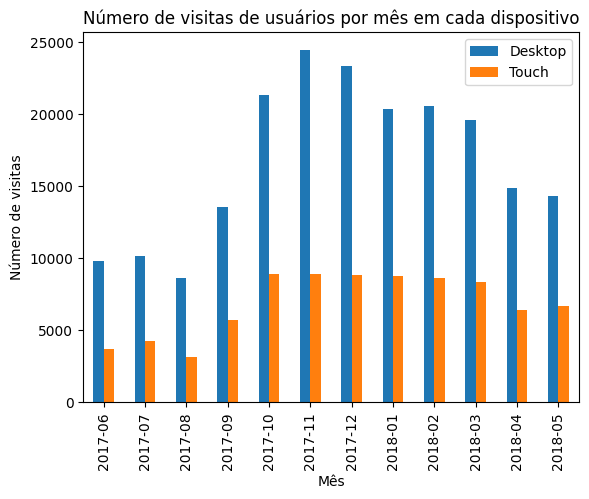

In [36]:
# cria um gráfico de barras do dataframe
plt.figure(figsize=(13, 9))

monthly_users_by_device.plot(kind='bar')

plt.title('Número de visitas de usuários por mês em cada dispositivo')
plt.xlabel('Mês')
plt.ylabel('Número de visitas')
plt.legend(['Desktop', 'Touch'], bbox_to_anchor=(1,1)) 

plt.show()
plt.close()

Percebe-se que, em todos os meses, há uma predominância de visitas realizadas por desktop.

 #### Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).


In [37]:
# calcula o número médio de sessões por dia
daily_sessions = visits.groupby('visit_date').agg({'uid':'count'}).mean()
print('Número médio de sessões por dia:', int(daily_sessions.iloc[0]))

Número médio de sessões por dia: 987


Com base nos dados apresentados, podemos concluir que:

* O número médio de usuários por dia é de 907, o que indica um fluxo constante de visitantes diários ao site.

* A média de usuários por semana é de 5.716, sugerindo que a base de usuários cresce consideravelmente ao longo da semana, com um aumento significativo nas interações no período semanal.

* O número médio de usuários por mês é de 23.228, o que representa um grande volume de visitantes ao longo do mês, refletindo um engajamento consistente ao longo do tempo.

* O número médio de sessões por dia é de 987, o que indica que, em média, cada usuário realiza múltiplas sessões diariamente. Isso sugere um bom nível de engajamento, com os usuários voltando várias vezes ao longo do dia.

Esses resultados indicam que, embora o site tenha um bom número de usuários diários, semanais e mensais, a alta quantidade de sessões diárias também sugere que os visitantes estão interagindo frequentemente com o conteúdo, o que pode ser um indicador de bom engajamento, mas também de que o site tem um uso repetido, talvez devido a características do conteúdo ou ao comportamento dos usuários.

In [38]:
# cálculo do número de sessões a cada dia para cada tipo de dispositivo

daily_visits_by_device = visits.pivot_table(index='visit_date',
                                       columns='device',
                                       values='uid',
                                       aggfunc='count',
                                       observed=False)

avg_daily_visits = round(daily_visits_by_device.mean(),2)
avg_daily_visits

device
desktop    721.34
touch      266.02
dtype: float64

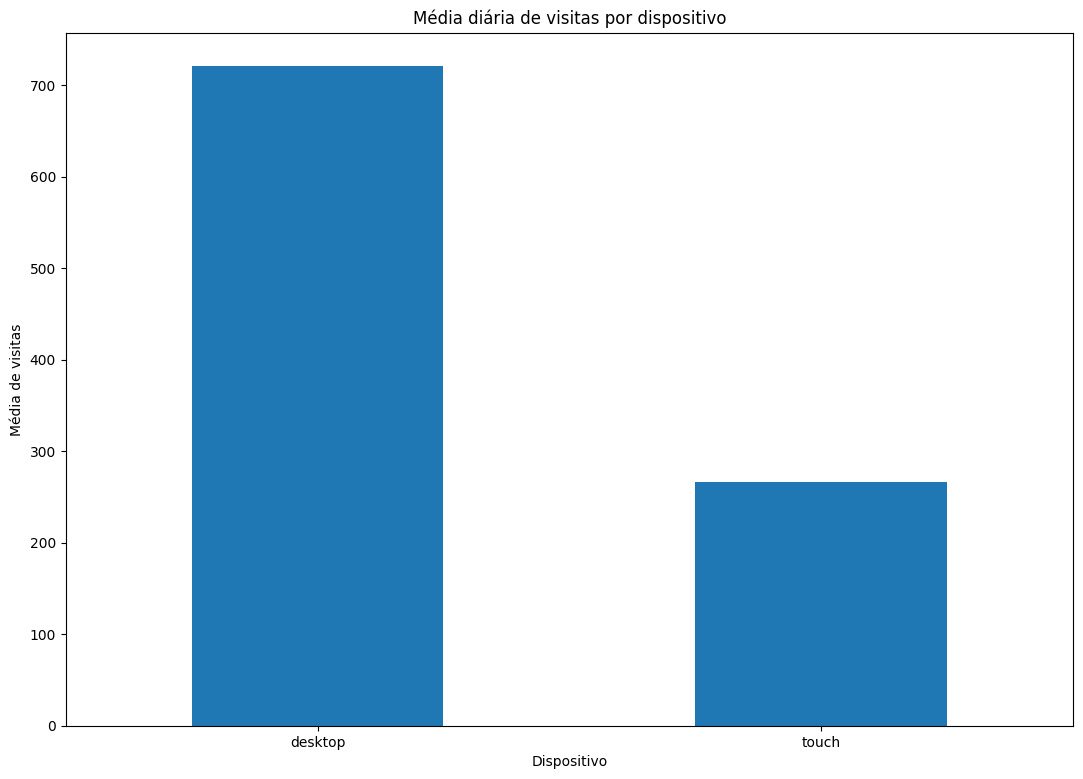

In [39]:
# gráfico de barras
plt.figure(figsize=(13, 9))

avg_daily_visits.plot(kind='bar')

plt.title('Média diária de visitas por dispositivo')
plt.xlabel('Dispositivo')
plt.ylabel('Média de visitas')
plt.xticks(rotation=0)

plt.show()
plt.close()

Percebe-se que a média de visitas diárias por dispositivos desktop são consideravemente maiores que as visitas realizadas em dispositivos touch.

#### Que comprimento tem cada sessão?


<Axes: >

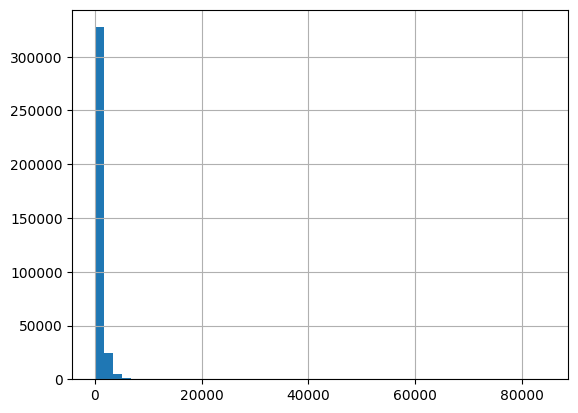

In [40]:
# calcula a duração de cada sessão em segundos e gera um histograma dos dados
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins=50)

Percebe-se que a maioria das sessões são muito curtas, mas ainda assim há algumas mais longas. Como a distribuição do tempo das sessões não é normal, o valor médio da sessão (`asl`) será encontrado pela moda (`.mode()`).

In [41]:
# encontra a duração média da sessão
asl = visits['session_duration_sec'].mode() 
print('O tempo médio (em segundos) de cada sessão é:', asl.loc[0])

O tempo médio (em segundos) de cada sessão é: 60


Com base no resultado fornecido, podemos concluir que o tempo médio de cada sessão é de 60 segundos, o que indica que, em média, os usuários permanecem no site por apenas um minuto por sessão.

Esse valor pode sugerir que as sessões são relativamente curtas. Isso pode ser interpretado de diferentes maneiras:

Engajamento breve: Pode ser que os usuários estejam visitando o site para realizar ações rápidas ou buscar informações específicas, sem se prolongar por muito tempo em cada sessão.

Conteúdo de baixa retenção: Se o tempo médio de sessão for muito baixo, pode indicar que os usuários não estão encontrando o conteúdo ou as funcionalidades do site suficientemente atraentes para permanecer por mais tempo. Nesse caso, estratégias para aumentar o tempo de engajamento, como melhorias no conteúdo, navegação ou funcionalidades interativas, poderiam ser consideradas.

Se for necessário, você pode investigar mais a fundo os motivos por trás de sessões tão curtas, como a análise de comportamento do usuário ou a otimização da experiência no site.

#### Com que frequência os usuários voltam?

In [42]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   uid                   359400 non-null  uint64        
 1   device                359400 non-null  category      
 2   source_id             359400 non-null  int64         
 3   start_ts              359400 non-null  datetime64[ns]
 4   end_ts                359400 non-null  datetime64[ns]
 5   visit_month           359400 non-null  period[M]     
 6   visit_week            359400 non-null  period[W-SUN] 
 7   visit_date            359400 non-null  period[D]     
 8   session_duration_sec  359400 non-null  int32         
dtypes: category(1), datetime64[ns](2), int32(1), int64(1), period[D](1), period[M](1), period[W-SUN](1), uint64(1)
memory usage: 20.9 MB


In [43]:
# agrupa os dados dos usuários do df visits e encontra o menor valor de visit_month, ou seja, encontra a primeira visita de cada usuário
first_visits = visits.groupby('uid')['visit_month'].min()
first_visits.name = 'first_visit_month'

In [44]:
# junta os dados dos usuários com os dados das primeiras visitas
visits = visits.join(first_visits, on='uid')
visits.head()

,uid,device,source_id,start_ts,end_ts,visit_month,visit_week,visit_date,session_duration_sec,first_visit_month
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12,2017-12-18/2017-12-24,2017-12-20,1080,2017-12
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02,2018-02-19/2018-02-25,2018-02-19,1680,2018-02
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07,2017-06-26/2017-07-02,2017-07-01,0,2017-07
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05,2018-05-14/2018-05-20,2018-05-20,1440,2018-03
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12,2017-12-25/2017-12-31,2017-12-27,0,2017-12


In [45]:
# calcula a vida útil de cada visita em meses
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']).apply(lambda x: x.n)

# amostra de dados do df para verificar a nova coluna
visits.head()

,uid,device,source_id,start_ts,end_ts,visit_month,visit_week,visit_date,session_duration_sec,first_visit_month,lifetime
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12,2017-12-18/2017-12-24,2017-12-20,1080,2017-12,0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02,2018-02-19/2018-02-25,2018-02-19,1680,2018-02,0
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07,2017-06-26/2017-07-02,2017-07-01,0,2017-07,0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05,2018-05-14/2018-05-20,2018-05-20,1440,2018-03,2
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12,2017-12-25/2017-12-31,2017-12-27,0,2017-12,0


In [46]:
# calcula a coorte de usuários por mês de primeira visita e tempo de vida
cohort = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()

In [47]:
cohort.head()

,first_visit_month,lifetime,uid
0,2017-06,0,13259
1,2017-06,1,1043
2,2017-06,2,713
3,2017-06,3,814
4,2017-06,4,909


In [48]:
# seleciona a coorte inicial (lifetime == 0) e renomeia a coluna de contagem de usuários
inicial = cohort[cohort['lifetime'] == 0][['first_visit_month', 'uid']]
inicial = inicial.rename(columns={'uid': 'n_users'})

In [49]:
inicial

,first_visit_month,n_users
0,2017-06,13259
12,2017-07,13140
23,2017-08,10181
33,2017-09,16704
42,2017-10,25977
50,2017-11,27248
57,2017-12,25268
63,2018-01,22624
68,2018-02,22197
72,2018-03,20589


In [50]:
# junta a coorte inicial com a coorte completa e calcula a taxa de retenção em porcentagem
cohort = cohort.merge(inicial, on='first_visit_month')
cohort['retention'] = cohort['uid'] / cohort['n_users']

In [51]:
cohort

,first_visit_month,lifetime,uid,n_users,retention
0,2017-06,0,13259,13259,1.000000
1,2017-06,1,1043,13259,0.078664
2,2017-06,2,713,13259,0.053775
3,2017-06,3,814,13259,0.061392
4,2017-06,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03,1,861,20589,0.041818
74,2018-03,2,557,20589,0.027053
75,2018-04,0,15709,15709,1.000000
76,2018-04,1,760,15709,0.048380


In [52]:
# cria uma tabela dinâmica de retenção por mês de primeira visita e tempo de vida
retention_pivot = cohort.pivot_table(
    index='first_visit_month',
    columns='lifetime', 
    values='retention', 
    aggfunc='sum')

retention_pivot_filtered = retention_pivot.drop(columns=0, errors='ignore')

# Converte para porcentagem (mantendo valores numéricos)
retention_pivot_filtered

lifetime,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,
2017-06,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


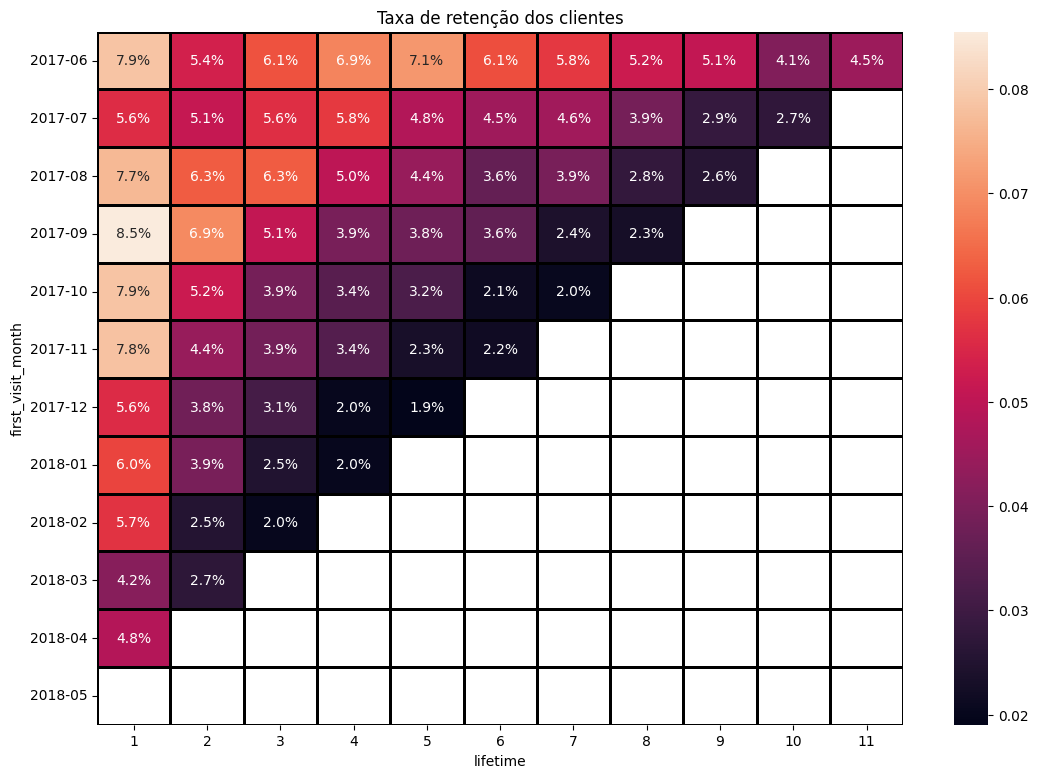

In [53]:
# formata os valores da série para porcentagem com 1 casa decimal, substituindo NaN por string vazia
annot = retention_pivot_filtered.map(lambda x: f'{x:.1%}' if pd.notnull(x) else '')

# cria um heatmap do dataframe
plt.figure(figsize=(13, 9))
plt.title('Taxa de retenção dos clientes')
sns.heatmap(
   retention_pivot_filtered,
    annot=annot,
    fmt='',
    linewidths=1,
    linecolor='black'
)

plt.yticks(rotation=0)
plt.show()
plt.close()


Percebe-se que as taxas de retenção diminuem tanto ao longo dos meses quanto conforme o tempo de vida do cliente aumenta. 

Em alguns meses, como setembro de 2017 (2017-09), começaram com uma retenção alta (8,5% no lifetime 1), mas ainda mostraram declínio acentuado. Isso pode refletir sazonalidade ou campanhas específicas que atraíram clientes, mas não os mantiveram.

Em 2018, as taxas iniciais (lifetime 1) já são mais baixas (6,0% em janeiro, 5,7% em fevereiro, 4,2% em março, 4,8% em abril), indicando possíveis problemas recentes na atração ou retenção de clientes.

### df `orders`
Serão analisadas as questões:
* Quando as pessoas começam a comprar?
* Quantos pedidos os clientes fazem durante um determinado período de tempo?
* Qual é o volume médio de uma compra?
* Quanto dinheiro eles trazem para a empresa (LTV)?

#### Quando as pessoas começam a comprar?
Para verificar em quanto tempo após o primeiro acesso as pessoas fazem a primeira compra, é necessário:
* agrupar os dados da tabela `visits` por usuário e descobrir a data da primeira visita (`first_vitis_dates`)
* agrupar os dados da tabela `orders` por usuário e descobrir a data da primeira compra (`first_order_date`)
* juntar as duas tabelas criadas pela coluna `uid`
* criar novas colunas com o mês da primeira visita e da primeira compra de cada usuário
* criar uma tabela dinâmica e um heatmap com coortes de acordo com o período de tempo entre a primeira visita e a conversão

In [54]:
# agrupa os dados dos usuários do df visits e encontra o menor valor de visit_month, ou seja, encontra a primeira visita de cada usuário
first_visits = visits.groupby('uid')['visit_month'].min().reset_index()
first_visits.columns=['uid', 'first_visit_month']
first_visits.head()

,uid,first_visit_month
0,11863502262781,2018-03
1,49537067089222,2018-02
2,297729379853735,2017-06
3,313578113262317,2017-09
4,325320750514679,2017-09


In [55]:
# agrupa os dados dos usuários do df orders e encontra o menor valor de order_month, ou seja, encontra a primeira compra de cada usuário
first_orders = orders.groupby('uid')['order_month'].min().reset_index()
first_orders.columns=['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01
1,1575281904278712,2017-06
2,2429014661409475,2017-10
3,2464366381792757,2018-01
4,2551852515556206,2017-11


In [56]:
# cria um df com a primeira visita e primeira compra de cada usuário
conversion_time = pd.merge(first_visits, first_orders, on='uid')
conversion_time.head()

,uid,first_visit_month,first_order_month
0,313578113262317,2017-09,2018-01
1,1575281904278712,2017-06,2017-06
2,2429014661409475,2017-10,2017-10
3,2464366381792757,2018-01,2018-01
4,2551852515556206,2017-11,2017-11


In [57]:
#  cria tabela dinâmica com coortes de acordo com o período de tempo entre a primeira visita e a conversão
conversion_time_pivot = conversion_time.pivot_table(
    index='first_visit_month',
    columns='first_order_month',
    values='uid',
    aggfunc='nunique'
)
conversion_time_pivot

first_order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
first_visit_month,,,,,,,,,,,,,
2017-06,2023.0,170.0,67.0,107.0,119.0,92.0,78.0,59.0,64.0,64.0,26.0,54.0,NaN
2017-07,NaN,1753.0,95.0,99.0,100.0,89.0,77.0,67.0,62.0,50.0,33.0,33.0,NaN
2017-08,NaN,NaN,1208.0,118.0,92.0,73.0,65.0,38.0,39.0,38.0,25.0,25.0,NaN
2017-09,NaN,NaN,NaN,2257.0,268.0,143.0,102.0,59.0,76.0,71.0,40.0,42.0,NaN
2017-10,NaN,NaN,NaN,NaN,3761.0,327.0,178.0,114.0,97.0,92.0,49.0,60.0,NaN
2017-11,NaN,NaN,NaN,NaN,NaN,3357.0,392.0,155.0,102.0,127.0,64.0,65.0,NaN
2017-12,NaN,NaN,NaN,NaN,NaN,NaN,3491.0,237.0,115.0,112.0,45.0,74.0,NaN
2018-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2644.0,244.0,114.0,50.0,67.0,NaN
2018-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2852.0,202.0,62.0,70.0,NaN


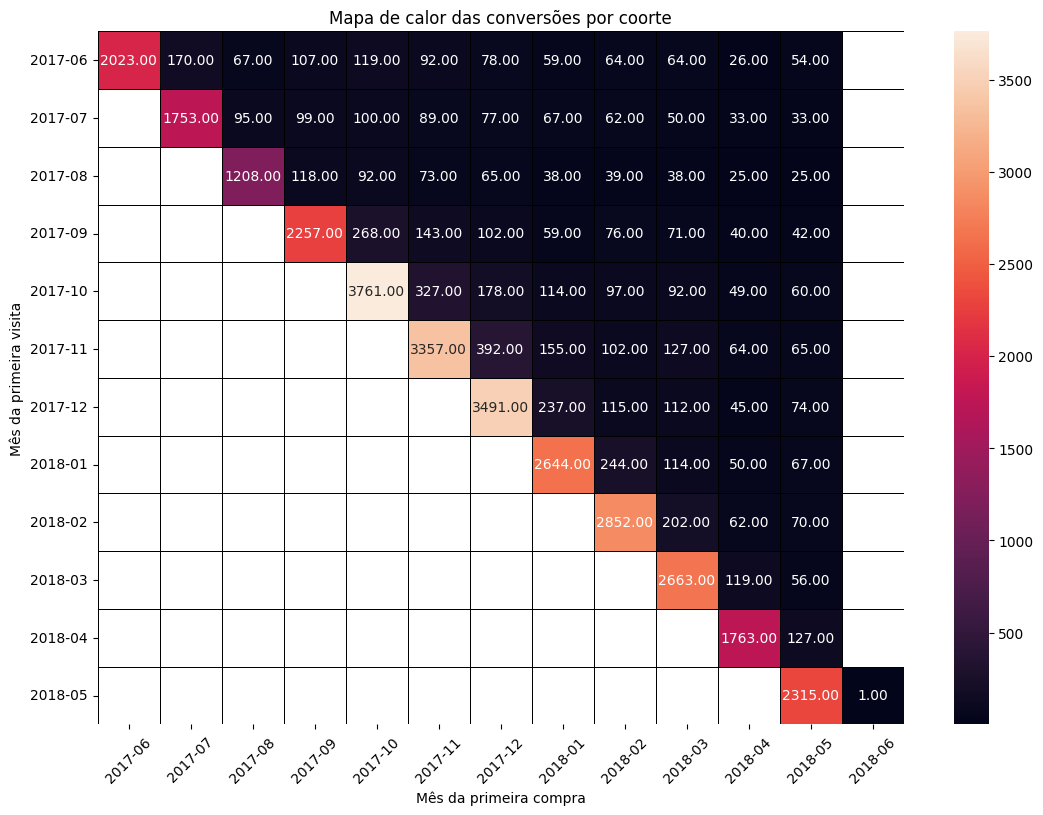

In [58]:
# cria um heatmap do dataframe
plt.figure(figsize=(13, 9))

sns.heatmap(
    conversion_time_pivot,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    linecolor='black'
)

plt.title("Mapa de calor das conversões por coorte")
plt.xlabel("Mês da primeira compra")
plt.ylabel("Mês da primeira visita")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Observa-se que a maioria dos usuários realiza a primeira compra no mesmo mês em que acessa o site pela primeira vez, o que indica uma conversão rápida de visitantes em clientes. No entanto, mesmo com a queda natural no número de conversões ao longo dos meses seguintes, ainda há usuários que efetuam a compra após algum tempo, sugerindo que parte do público precisa de um período maior para tomar a decisão de compra.

As coortes dos meses de outubro, novembro e dezembro de 2017 apresentaram os melhores desempenhos, o que pode refletir o sucesso de campanhas de marketing mais eficazes nesse período ou ser resultado da sazonalidade associada às festas de fim de ano.

#### Quantos pedidos os clientes fazem durante um determinado período de tempo?
Para verificar a quantidade de pedidos que os clientes fazem durante um determinado período de tempo, é necessário:
* agrupar os dados por id de usuário e mês de compra para realizar a contagem de pedidos realizados mensalmente
* analisar as estatísticas do número de pedidos por usuário por mês
* gerar gráfico para facilitar a visualização da distribuição de frequência de pedidos por mês
* calcular a medida mais apropriada para representar o número típico de pedidos mensais por cliente


In [59]:
# conta a quantidade de pedidos de cada usuário em cada mês
monthly_orders = orders.groupby(['uid','order_month'])['buy_ts'].count().reset_index()
monthly_orders.columns=['uid', 'order_month', 'order_count']
monthly_orders.head()

,uid,order_month,order_count
0,313578113262317,2018-01,1
1,1575281904278712,2017-06,2
2,2429014661409475,2017-10,1
3,2464366381792757,2018-01,1
4,2551852515556206,2017-11,2


In [60]:
# calcula estatísticas
monthly_orders.describe()

,uid,order_count
count,4.101900e+04,41019.000000
mean,9.201097e+18,1.229065
std,5.323180e+18,1.384665
min,3.135781e+14,1.000000
25%,4.613384e+18,1.000000
50%,9.239923e+18,1.000000
75%,1.381082e+19,1.000000
max,1.844617e+19,67.000000


Em média, os usuários fazem 1.22 pedidos por mês. Pelo menos 50% dos usuários fazem apenas 1 pedido nesse período. Alguns usuários fizeram até 67 pedidos em um único mês (clientes frequentes).

Percebe-se que o desvio padrão (std) do número de pedidos por mês está próxima da média, indicando que há variabilidade em relação à média. 

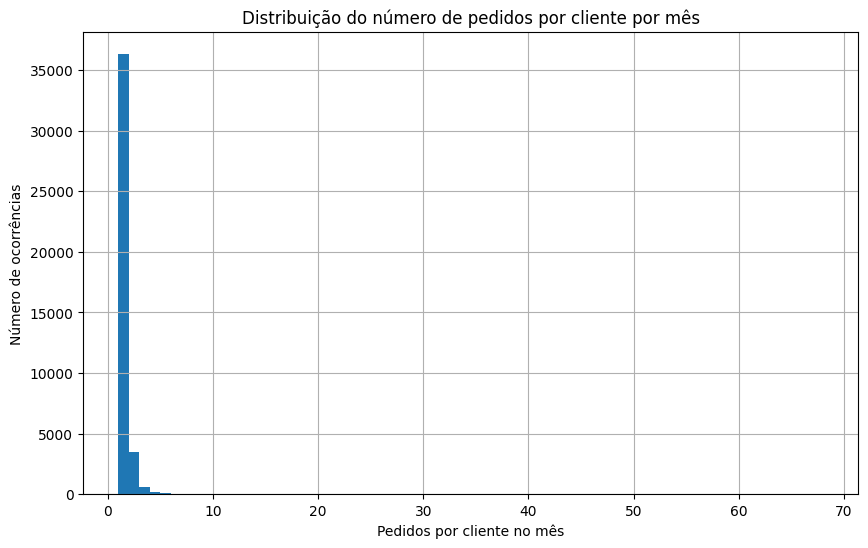

In [61]:
# gera gráfico de histograma de número de pedidos por cliente por mês

plt.figure(figsize=(10, 6))

monthly_orders['order_count'].hist(bins=range(1, monthly_orders['order_count'].max() + 2))

plt.xlabel('Pedidos por cliente no mês')
plt.ylabel('Número de ocorrências')
plt.title('Distribuição do número de pedidos por cliente por mês')
plt.show()
plt.close()

A esmagadora maioria dos usuários faz apenas 1 ou 2 pedidos por mêsmas ainda há uma longa cauda de usuários que fazem 10, 20 ou até mais de 60 pedidos por mês (usuários frequentes). 

Com isso, a mediana é a medida que representa melhor a quantidade típica de compras realizadas por cliente por mês.

In [62]:
print('A maioria dos clientes faz ', monthly_orders['order_count'].median(), 'pedido(s) por mês')

A maioria dos clientes faz  1.0 pedido(s) por mês


#### Qual é o volume médio de uma compra?

Para fazer este cálculo, primeiramente é necessário verificar a descrição estatística da coluna `revenue` do df `orders`, que possui os dados da receita de cada compra realizada no site.

In [63]:
orders.head()

,uid,buy_ts,order_month,revenue
0,10329302124590727494,2017-06-01 00:10:00,2017-06,17.00
1,11627257723692907447,2017-06-01 00:25:00,2017-06,0.55
2,17903680561304213844,2017-06-01 00:27:00,2017-06,0.37
3,16109239769442553005,2017-06-01 00:29:00,2017-06,0.55
4,14200605875248379450,2017-06-01 07:58:00,2017-06,0.37


In [64]:
# calcula estatísticas
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Percebe-se que o desvio padrão (std) das receitas de cada pedido é muito maior que a média, indicando que há uma alta dispersão (muitos outliners) no df - uma distribuição assimétrica. 

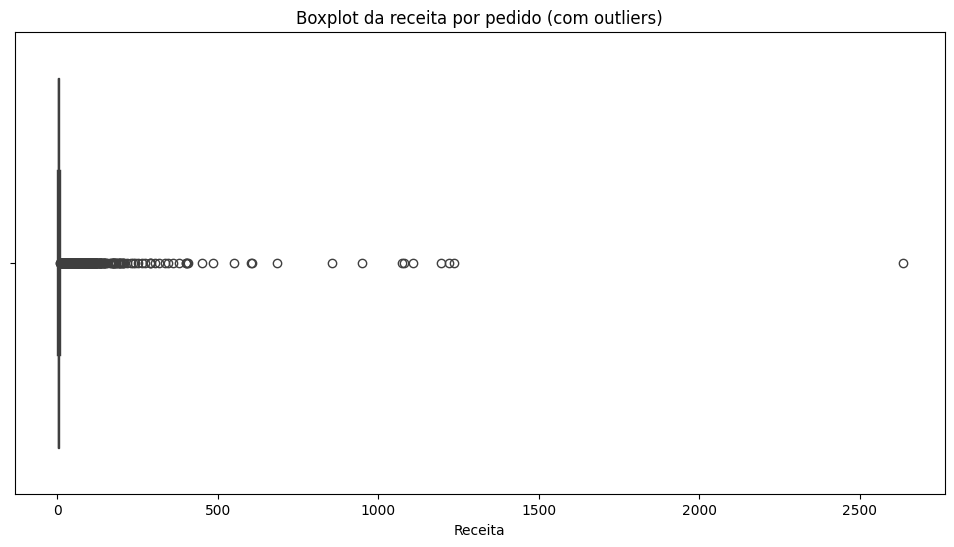

In [65]:
# gera boxplot da receita por pedido
plt.figure(figsize=(12, 6))
sns.boxplot(x='revenue', data=orders)
plt.title('Boxplot da receita por pedido (com outliers)')
plt.xlabel('Receita')
plt.show()
plt.close()


O gráfico mostra que a maioria dos pedidos tem valores concentrados à esquerda (valores baixos), mas há outliers extremos que se estendem muito à direita. Isso reforça que a mediana é mais apropriada para calcular o volume médio de compra de forma realista.

In [66]:
print('O volume médio da receita por pedido é:', orders['revenue'].median())

O volume médio da receita por pedido é: 2.5


Também será calculada a receita gerada a partir de cada tipo de dispositivo (`device`) por mês.
Para isso, é preciso juntar a informação sobre as origens e dispositivos da tabela `visits` à tabela `orders`.

In [67]:
# cria uma tabela com os pedidos e suas respectivas fontes
orders_with_source = orders.merge(
    visits[['uid', 'visit_month', 'source_id', 'device']],
    left_on=['uid', 'order_month'],
    right_on=['uid', 'visit_month'],
    how='left' 
)

orders_with_source['source_id'] = orders_with_source['source_id'].astype('Int64')
orders_with_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184801 entries, 0 to 184800
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uid          184801 non-null  uint64        
 1   buy_ts       184801 non-null  datetime64[ns]
 2   order_month  184801 non-null  period[M]     
 3   revenue      184801 non-null  float64       
 4   visit_month  181786 non-null  period[M]     
 5   source_id    181786 non-null  Int64         
 6   device       181786 non-null  category      
dtypes: Int64(1), category(1), datetime64[ns](1), float64(1), period[M](2), uint64(1)
memory usage: 8.8 MB


In [68]:
#  cria tabela dinâmica com o total de renda gerada a partir de cada fonte e tipo de dispositivo
revenue_source_device = orders_with_source.pivot_table(
    index='source_id',
    columns='device',
    values='revenue',
    aggfunc='sum',
    observed=False
)
revenue_source_device

device,desktop,touch
source_id,,
1,341417.82,54856.02
2,588870.59,45345.17
3,91248.93,10974.86
4,103146.26,26099.02
5,197010.31,9858.50
7,1.22,0.00
9,8215.51,1904.96
10,5397.97,1788.00


<Figure size 1300x900 with 0 Axes>

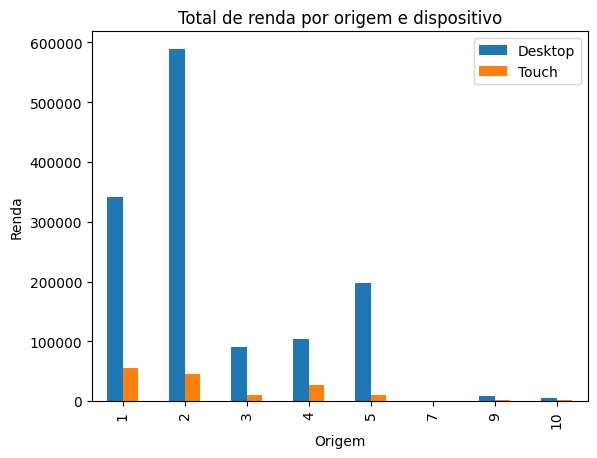

In [69]:
# cria um gráfico de barras do dataframe
plt.figure(figsize=(13, 9))

revenue_source_device.plot(kind='bar')

plt.title('Total de renda por origem e dispositivo')
plt.xlabel('Origem')
plt.ylabel('Renda')
plt.legend(['Desktop', 'Touch'], bbox_to_anchor=(1,1)) 

plt.show()
plt.close()

* Percebemos que usuários de dispositivos Desktop geram muito mais receita do que usuários de dispositivos Touch em todas as origens. 
* As origens 1 e 2 geraram a maior parte da renda total, tanto para os dispositivos desktop quanto para os touch. 
* As origens 4 e 5 têm uma presença um pouco mais equilibrada entre dispositivos, mas ainda assim o desktop domina.
* As origens 6 e 8 não geraram renda, enquanto as 7, 8 e 9 praticamente não geraram receita. 


#### Quanto dinheiro eles trazem para a empresa (LTV)?
Para calcular a quantidade total de dinheiro que um cliente médio traz para a empresa, é preciso:
* incluir a data da primeira compra de cada cliente na tabela orders (já temos essa informação na tabela first_orders)
* calcular o número de novos clientes para cada data
* agrupar a tabela e calcular a receita por coorte por mês

In [70]:
orders

,uid,buy_ts,order_month,revenue
0,10329302124590727494,2017-06-01 00:10:00,2017-06,17.00
1,11627257723692907447,2017-06-01 00:25:00,2017-06,0.55
2,17903680561304213844,2017-06-01 00:27:00,2017-06,0.37
3,16109239769442553005,2017-06-01 00:29:00,2017-06,0.55
4,14200605875248379450,2017-06-01 07:58:00,2017-06,0.37
...,...,...,...,...
50410,12296626599487328624,2018-05-31 23:50:00,2018-05,4.64
50411,11369640365507475976,2018-05-31 23:50:00,2018-05,5.80
50412,1786462140797698849,2018-05-31 23:54:00,2018-05,0.30
50413,3993697860786194247,2018-05-31 23:56:00,2018-05,3.67


In [ ]:
# constrói coortes de acordo com a primeira compra
cohort_first_order = pd.merge(orders, first_orders, on='uid')
cohort_first_order.head()

,uid,buy_ts,order_month,revenue,first_order_month
0,10329302124590727494,2017-06-01 00:10:00,2017-06,17.00,2017-06
1,11627257723692907447,2017-06-01 00:25:00,2017-06,0.55,2017-06
2,17903680561304213844,2017-06-01 00:27:00,2017-06,0.37,2017-06
3,16109239769442553005,2017-06-01 00:29:00,2017-06,0.55,2017-06
4,14200605875248379450,2017-06-01 07:58:00,2017-06,0.37,2017-06


In [ ]:
# Calculando a diferença em meses entre a compra atual e a primeira compra
cohort_first_order['month_diff'] = (cohort_first_order['order_month'].astype('int64') - cohort_first_order['first_order_month'].astype('int64'))

In [ ]:
# Calculando o número de compradores por coorte
cohort_first_order_sizes = cohort_first_order.groupby('first_order_month')['uid'].nunique().reset_index()
cohort_first_order_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

In [ ]:
cohort_first_order_sizes.head()

,first_order_month,n_buyers
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340


In [ ]:
# Mesclando o DataFrame de cohort sizes com o DataFrame original
cohort_first_order = pd.merge(cohort_first_order, cohort_first_order_sizes, left_on='first_order_month', right_on='first_order_month')

In [ ]:
cohort_first_order.head()

,uid,buy_ts,order_month,revenue,first_order_month,month_diff,n_buyers
0,10329302124590727494,2017-06-01 00:10:00,2017-06,17.00,2017-06,0,2023
1,11627257723692907447,2017-06-01 00:25:00,2017-06,0.55,2017-06,0,2023
2,17903680561304213844,2017-06-01 00:27:00,2017-06,0.37,2017-06,0,2023
3,16109239769442553005,2017-06-01 00:29:00,2017-06,0.55,2017-06,0,2023
4,14200605875248379450,2017-06-01 07:58:00,2017-06,0.37,2017-06,0,2023


In [ ]:
# Calculando o LTV para cada coorte e período de tempo (em meses) após a primeira compra
cohort_first_order['ltv'] = cohort_first_order['revenue'] / cohort_first_order['n_buyers']

In [ ]:
output = cohort_first_order.pivot_table(
    index='first_order_month',
    columns='month_diff',
    values='ltv',
    aggfunc='sum'
)
output

month_diff,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Calculando o LTV acumulado ao longo do tempo para cada coorte
ltv_cumsum = output.cumsum(axis=1).round(2)

In [80]:
# Substituindo strings vazias por NaN
ltv_cumsum.replace('', np.nan, inplace=True)

In [81]:
ltv_cumsum

month_diff,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


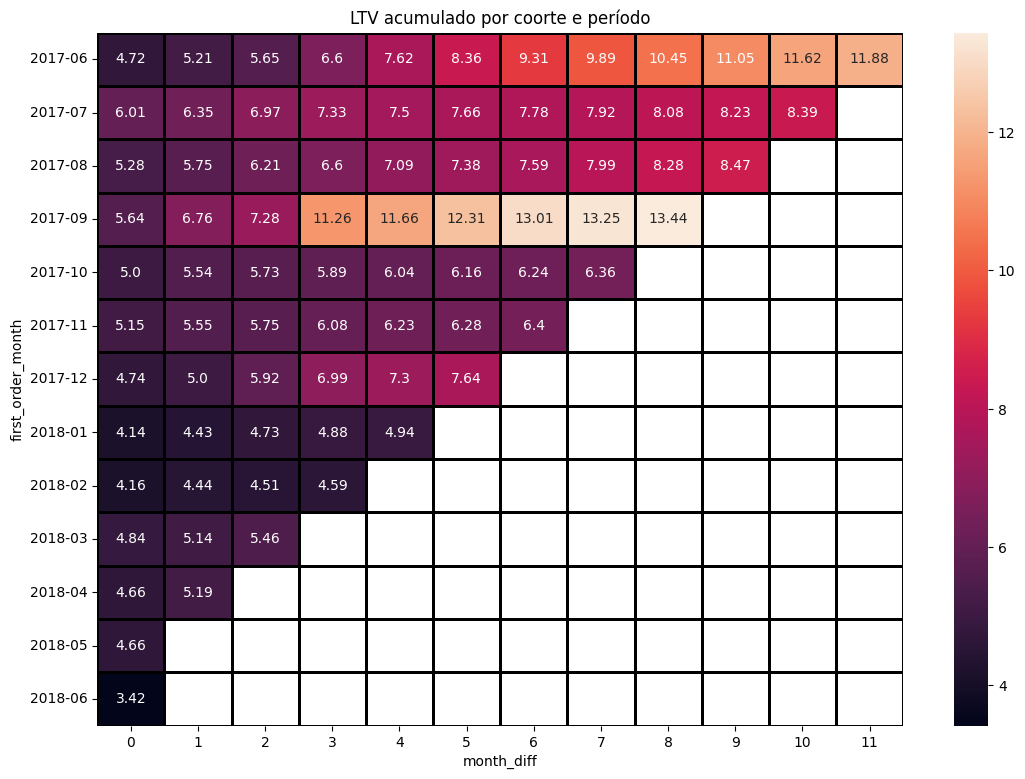

In [82]:
# Por fim, geramos um heatmap para visualizar o LTV acumulado por coorte e período.


# cria um heatmap do dataframe
plt.figure(figsize=(13, 9))
plt.title('LTV acumulado por coorte e período')
sns.heatmap(
   ltv_cumsum,
   annot=True,
    fmt='',
    linewidths=1,
    linecolor='black'
)

plt.yticks(rotation=0)
plt.show()
plt.close()



Percebe-se que as células vão ficando mais claras (valores mais altos) à medida que o month_diff aumenta, o que indica que os clientes contiunuam gerando receita mesmo meses após aprimeira compra, fazendo O LTV crescer ao longo do tempo. Além disso, a coorte de 2017-09 destaca-se por crescimento de LTV mais rápido, o que pode indicar uma campanha de aquisição ou produto que teve melhor performance de retenção.


### df `costs` 
Serão analisadas as questões:
* Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo
* Quanto custou a aquisição de clientes para cada origem? (CAC)
* Os investimentos valeram a pena? (ROI)

#### Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo

In [83]:
# calcula a soma de todos os gastos
total_costs = costs['costs'].sum()
print('O total de gastos foi:', total_costs)

O total de gastos foi: 329131.62


In [84]:
# agrupa os gastos por fonte e faz a soma 
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


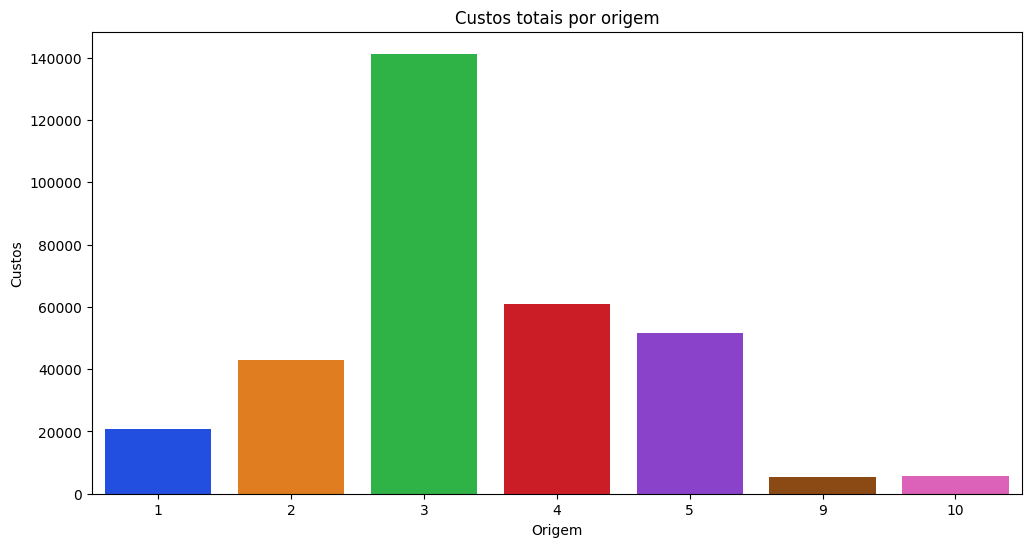

In [85]:
# cria um gráfico de barras dos custos por origem
plt.figure(figsize=(12, 6))
sns.barplot(
    x='source_id',
    y='costs',
    data=costs_by_source,
    palette='bright',
    hue='source_id',
    legend=False)

plt.title('Custos totais por origem')
plt.xlabel('Origem')
plt.ylabel('Custos')

plt.show()
plt.close()


A origem de id 3 foi disparadamente a que teve maior investimento - foi mais que o dobro de custos se comparado com a origem de id 4, que é a que representou o segundo maior valor total de custos. As origens 4 e 5 também receberam investimento significativo, mesmo que bem menores que a origem 3; já as origens 9 e 10 tiveram custos muito mais baixos.

In [86]:
# agrupa os gastos por mês e faz a soma
costs_by_month = costs.groupby('cost_month')['costs'].sum().reset_index()
costs_by_month

,cost_month,costs
0,2017-06,18015.00
1,2017-07,18240.59
2,2017-08,14790.54
3,2017-09,24368.91
4,2017-10,36322.88
5,2017-11,37907.88
6,2017-12,38315.35
7,2018-01,33518.52
8,2018-02,32723.03
9,2018-03,30415.27


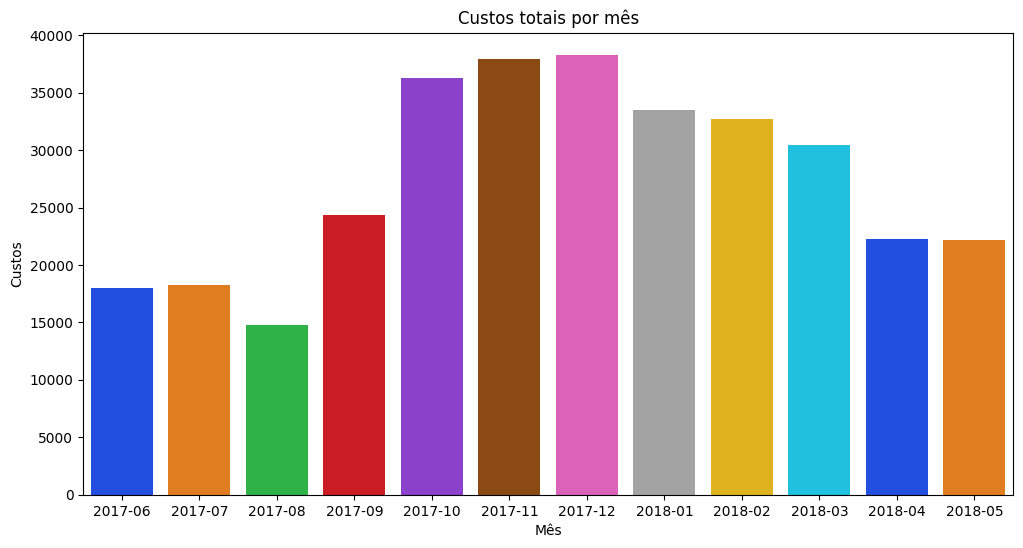

In [87]:
# cria um gráfico de barras dos custos por mês
plt.figure(figsize=(12, 6))
sns.barplot(
    x='cost_month',
    y='costs',
    data=costs_by_month,
    palette='bright',
    hue='cost_month',
    legend=False)

plt.title('Custos totais por mês')
plt.xlabel('Mês')
plt.ylabel('Custos')

plt.show()
plt.close()


Com este gráfico é possível notar que os meses com maiores custos foram os 3 meses finais de 2017 e os 3 primeiros meses de 2018, provavelmente devido ao período festivo e de compra e troca de presentes. Além disso, percebe-se que os custos crescera, emtre agosto de 2017 até dezembro de 2018; depois, iniciou-se uma queda gradual dos investimentos, o que pode indicar uma otimização de gastos ou mudança de estratégia.

#### Quanto custou a aquisição de clientes para cada origem? (CAC)
Para verificar o custo de aquisição de clientes para cada origem, é preciso calcular o custo médio por cliente adquirido pela equação `CAC = custo / Quantidade de compradores (n_buyers)`

In [88]:
# calcula o tamanho das coortes source_id
cohort_source_sizes = orders_with_source.groupby('source_id').agg({'uid':'count'}).reset_index()
cohort_source_sizes.columns=['source_id', 'n_buyers']
cohort_source_sizes

,source_id,n_buyers
0,1,49311
1,2,51013
2,3,18533
3,4,22585
4,5,35071
5,7,1
6,9,2984
7,10,2288


In [89]:
cac = pd.merge(costs_by_source, cohort_source_sizes, on='source_id')
cac['cohort_cac'] = round((cac['costs'] / cac['n_buyers']), 2)
cac

,source_id,costs,n_buyers,cohort_cac
0,1,20833.27,49311,0.42
1,2,42806.04,51013,0.84
2,3,141321.63,18533,7.63
3,4,61073.60,22585,2.70
4,5,51757.10,35071,1.48
5,9,5517.49,2984,1.85
6,10,5822.49,2288,2.54


As origens 1 e 2 são as mais efeicientes, já que possuem um custo de aquisição de clientes mais baixo. A origem 3, no entando, possui um CAC muito alto, o que pode indicar um investimento com pouco retorno. 

#### Os investimentos valeram a pena? (ROI)

Para calcular o ROI da campanha, é preciso fazer o cálculo `ROI da campanha publicitária = LTV / CAC` por coorte.

In [90]:
cohorts_roi =  cohort.groupby(['first_order_month', 'order_month']).agg(
    revenue=('revenue','sum'), n_buyers=('uid', 'nunique')).reset_index()

cohorts_roi.head()

,first_order_month,order_month,revenue,n_buyers
0,2017-06,2017-06,9557.49,2023
1,2017-06,2017-07,981.82,61
2,2017-06,2017-08,885.34,50
3,2017-06,2017-09,1931.30,54
4,2017-06,2017-10,2068.58,88


In [91]:
# calcular a vida útil do coorte
cohorts_roi['cohort_lifetime'] = (cohorts_roi['order_month'] - cohorts_roi['first_order_month']).apply(lambda x: x.n)

# ordenar o dataframe por 'first_order_month' e 'cohort_lifetime'
cohorts_roi = cohorts_roi.sort_values(['first_order_month', 'cohort_lifetime'])

cohorts_roi.head()

,first_order_month,order_month,revenue,n_buyers,cohort_lifetime
0,2017-06,2017-06,9557.49,2023,0
1,2017-06,2017-07,981.82,61,1
2,2017-06,2017-08,885.34,50,2
3,2017-06,2017-09,1931.30,54,3
4,2017-06,2017-10,2068.58,88,4


In [95]:
costs

,source_id,dt,costs,cost_month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05
2538,10,2018-05-28,21.26,2018-05
2539,10,2018-05-29,11.32,2018-05
2540,10,2018-05-30,33.15,2018-05


In [97]:
# mesclar com os dados de custos
cost_per_month = costs.groupby('cost_month').agg(costs=('costs', 'sum')).reset_index()

cohorts_roi = pd.merge(cohorts_roi, cost_per_month, left_on='order_month', right_on='cost_month')

# calcular cac, ltv e romi
cohorts_roi['cac'] = cohorts_roi['costs'] / cohorts_roi['n_buyers']
cohorts_roi['ltv'] = cohorts_roi['revenue'] / cohorts_roi['n_buyers']
cohorts_roi['romi'] = cohorts_roi['ltv'] / cohorts_roi['cac']

cohorts_roi.head()

,first_order_month,order_month,revenue,n_buyers,cohort_lifetime,cost_month,costs,cac,ltv,romi
0,2017-06,2017-06,9557.49,2023,0,2017-06,18015.00,8.905091,4.724414,0.530530
1,2017-06,2017-07,981.82,61,1,2017-07,18240.59,299.026066,16.095410,0.053826
2,2017-06,2017-08,885.34,50,2,2017-08,14790.54,295.810800,17.706800,0.059859
3,2017-06,2017-09,1931.30,54,3,2017-09,24368.91,451.276111,35.764815,0.079253
4,2017-06,2017-10,2068.58,88,4,2017-10,36322.88,412.760000,23.506591,0.056950


In [98]:
# calcular a soma acumulada usando o comando cumsum
romi_cumsum = output.cumsum(axis=1).round(2)

# Substituindo strings vazias por NaN
romi_cumsum.replace('', np.nan, inplace=True)
romi_cumsum

month_diff,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


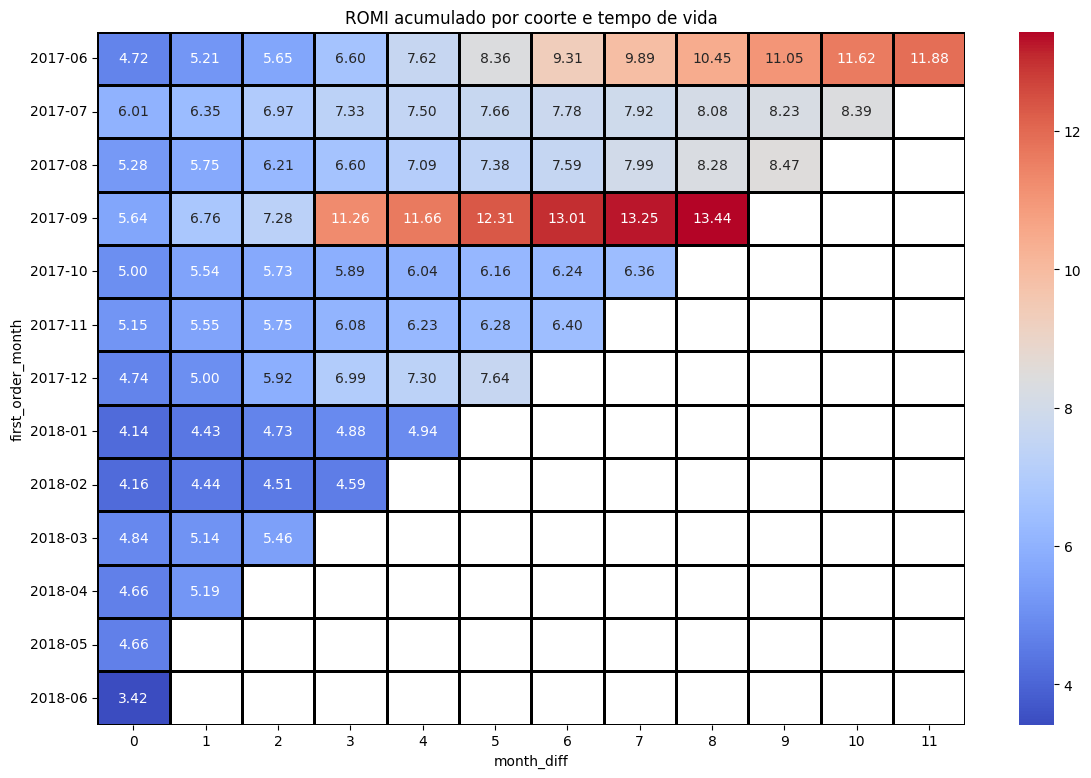

In [99]:
# visualizar o resultado

plt.figure(figsize=(14, 9))
plt.title('ROMI acumulado por coorte e tempo de vida')
sns.heatmap(
    romi_cumsum,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=1,
    linecolor='black'
)

plt.show()
plt.close()

Percebe-se que:
* O ROMI tende a crescer ao longo dos meses. 
* A coorte de 2017-09 destaca-se por ter teve um ROI acumulado de 13.44 em 10 meses
* As coortes 2017-06 a 2017-09 tiveram ROMI maior — talvez essas campanhas foram mais eficazes ou os canais usados trouxeram clientes com maior valor. Pode ser reflexo de menos competição, melhor segmentação, ou um produto novo no mercado.
* As coortes mais recentes (de 2018-03 em diante) ainda não tiveram tempo para maturar, por isso possuem ROMI menores.

Considerando que ROMI acima de 1 indica que a coorte já recuperou o investimento em marketing e está gerando lucro, conclui-se que o investimento valeu a pena. Ainda assim, nas coortes mais recentes, ainda não dá para afirmar com certeza se o investimento valeu a pena, mas os sinais são positivos, especialmente se o padrão de comportamento seguir os anteriores.

## 3. Conclusão

Para embasar as recomendações, foram analisadas as seguintes métricas principais:

* ROMI (retorno sobre investimento de marketing)
* CAC (custo de aquisição de clientes)
* LTV (valor do tempo de vida do cliente)
* Receita por origem e por dispositivo
* Frequência de pedidos e comportamento de coorte
* Engajamento por tipo de dispositivo (visitas, sessões, tempo de sessão)


**Recomendações de investimento em Marketing**
* Invistir mais nas origens 1 e 2: elas geram mais receita, têm baixo custo de aquisição (CAC) e bom retorno (ROI). São as origens com melhor custo-benefício.
* Reduzir o investimento na origem 3: apesar do alto custo, traz pouco retorno.
* Evitar investir mais nas origens 9 e 10, que quase não geram receita.
* Focar em estratégias para usuários de Desktop, que compram muito mais do que os de dispositivos Touch, e/ou testar/ ajustar as campanhas voltadas para o mobile.
* Há uma conversão rápida dos clientes: maioria compra no primeiro mês após a visita. No entanto, após isso, a taxa de retenção cai. Deve-se investir em retenção e no cliclo de vida do cliente - criar ações de pós-venda, remarketing e fidelização para aumentar o LTV mais rapidamente.
* A coorte de setembro de 2017 se destacou por melhor retenção (até 6 meses), LTV e ROMI com crescimento mais rápido. É interessante analisar o que foi feito nesta coorte (campanhas, canais, oferta) e replicar estratégias.